## Plots from Triaxus and shipboard ADCP across a finescale cold filament

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import math
import gsw
import matplotlib as mpl
import pyproj
from geographiclib.geodesic import Geodesic

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [ ]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [2]:
import imp
import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [3]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript', 'revision_figures')

In [4]:
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

# satellite altimetry
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

# FLSE
fsle_ds = imports.importNetCDF(datadir, 'FSLE.nc').rename({'lat':'latitude', 'lon':'longitude'})
fsle = fsle_ds.fsle_max

# Okubo-Weiss
ow = imports.importNetCDF(datadir, 'okubo_weiss.nc', datatype ='altimetry').okubo_weiss

#SST
sst_ds_0_02 = imports.importNetCDF(datadir, 'IMOS_aggregation_20220923T013201Z.nc', datatype ='sst')
sst_ds = sst_ds_0_02.rename({'lat':'latitude', 'lon':'longitude'})

# filter bad data (quality level < 3)
mask = (sst_ds.quality_level.data < 3)
sst = sst_ds.sea_surface_temperature
sst.data[mask] = np.nan
sst_deg = sst - 273.15

# half-inertial pair averaged float dataset
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
ds = imports.sub_inertial_ds(ema, floatids, fltdir, xdim = 'profile')

In [5]:
# import datetime

# ### import wind data from underway file 
# underway = imports.importNetCDF('Y:\IN2023_V07', 'in2018_v05uwy.nc')

# original = datetime.datetime(2018,1,1,0,0,0)
# start_time = original + datetime.timedelta(seconds=24901540)

# new_time = []
# for i in range(len(underway.sample.values)):
#     new_time.append(start_time + datetime.timedelta(seconds=5*int(underway.sample.values[i])))
# new_time=np.array(new_time)

# underway['sample']=new_time

In [6]:
# filename = 'IN2018_V05_underway.nc'
# savedir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
# settings.save_to_netCDF(underway, savedir, filename)

In [7]:
### import wind data from underway file 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
underway = imports.importNetCDF(datadir, 'IN2018_V05_underway.nc')

In [8]:
# Triaxus
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'

tow_list = ['01_002', '02_002', '02_005', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002', '08_003', '09_002', '09_003']

triaxus_cast = imports.triaxus_data(datadir, tow_list, folder)

In [10]:
#ADCP
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'adcp')
folder = 'in2018_v05_ADCP_nc'
file = 'in2018_v05_os150nb.nc'
adcp = imports.importNetCDF(datadir, file, datatype = folder)

In [11]:
def rot_vels(adcp_sel, smooth_gps = True, window = 17):
    '''Rotate ADCP velocities to along and cross-track.'''
    lons, lats = adcp_sel.lon, adcp_sel.lat
    if smooth_gps == True:
        try:
            lons = interp.gaussianFilter(lons, window = window)
            lats = interp.gaussianFilter(lats, window = window)
        except:
            lons = lons.rolling(time = 5, center = True, min_periods = 3).mean()
            lats = lats.rolling(time = 5, center = True, min_periods = 3).mean()

    depth = adcp_sel.depth[0]
    v = adcp_sel.v.assign_coords(depth_cell=depth.data)
    u = adcp_sel.u.assign_coords(depth_cell=depth.data)
    
    bearing = []
    for i in range(0, len(lats)-1):
        lat1, lat2 = lats[i], lats[i+1]
        lon1, lon2 = lons[i], lons[i+1]

        geodesic = pyproj.Geod(ellps='WGS84')  # WGS84 is the reference coordinate system (Earth's centre of mass) used by GPS. 
        # Inverse computation to calculate the forward and back azimuths and distance from two lat and lon coordinates. 
        fwd_azimuth = geodesic.inv(lon1, lat1, lon2, lat2)[0]

        # if the angle is negative (anticlockwise from N), add it to 360 to get the bearing clockwise from N.
        fwd_azimuth += 360
        fwd_azimuth = fwd_azimuth % 360

        if fwd_azimuth == 0:
            bearing.append(np.nan)
        else:
            bearing.append(fwd_azimuth)
            
    along_track = np.asarray(bearing)
    track_bearing = np.tile(along_track,(len(v.depth_cell), 1)).transpose()
    velocity_bearing = vel.uvBearing(u, v)

    # find the angle between the velocity bearing and the along stream direction
    theta = track_bearing - velocity_bearing[:-1]
    theta = (theta + 180) % 360 - 180

    speed = calc.speed(u, v)

    # calculate u and v using this new angle (converting degrees to radians)
    u_rot = speed * np.cos(theta*np.pi/180)
    v_rot = speed * np.sin(theta*np.pi/180)
    
    return u_rot, v_rot, track_bearing[:,0]
    

### Transect 4: across finescale cold filament

In [12]:
tow = '04_002'
triaxus_vertical_cast = triaxus_cast[tow]

lats = slice(-51,-57)
lons = slice(148,156)

In [13]:
start_sst = triaxus_vertical_cast.time.values[0] #-np.timedelta64(1, 'D')
end_sst = triaxus_vertical_cast.time.values[-1] #+ np.timedelta64(1, 'D')

start_time, end_time = str(start_sst.astype('M8[D]')), str(end_sst.astype('M8[D]'))
msst = sst_deg.sel(time = slice(start_time, end_time)).mean(dim = 'time').sel(latitude = lats, longitude = lons)

levels = np.arange(-0.8,0.4,0.1)
msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time').sel(latitude = slice(-57.5,-50.5), 
                                                                                   longitude = slice(147.5, 156.5))

In [14]:
start = triaxus_vertical_cast.time.values[0] #- np.timedelta64(1, 'D')
end = triaxus_vertical_cast.time.values[-1] #+ np.timedelta64(1, 'D')

flt_lons, flt_lats = [], []
for floatid in floatids:
    float_num = ema[floatid]
    nonats = np.where(~np.isnat(float_num.time))[0]
    
    flt_times = float_num.time[nonats].sel(time = slice(start, end))
    for t in flt_times:
        flt_ind = np.where(float_num.time[nonats] == t)
        flt_lons.append(float_num.longitude[nonats][flt_ind].data)
        flt_lats.append(float_num.latitude[nonats][flt_ind].data)


#### ADCP data minus 10 minutes to account for the spatial offset between the ship and the towed Triaxus

- Aligns GPS positions more closely (see figure below)

In [15]:
triaxus_vertical_cast.time.values[0] - np.timedelta64(10, 'm')

numpy.datetime64('2018-10-29T09:46:51.791321088')

In [16]:
adcp_minus10 = adcp.sel(time = slice(start - np.timedelta64(10, 'm'), end - np.timedelta64(10, 'm')))
adcp_zero_lag = adcp.sel(time = slice(start, end))

Text(0.5, 1.0, '10 minute lag')

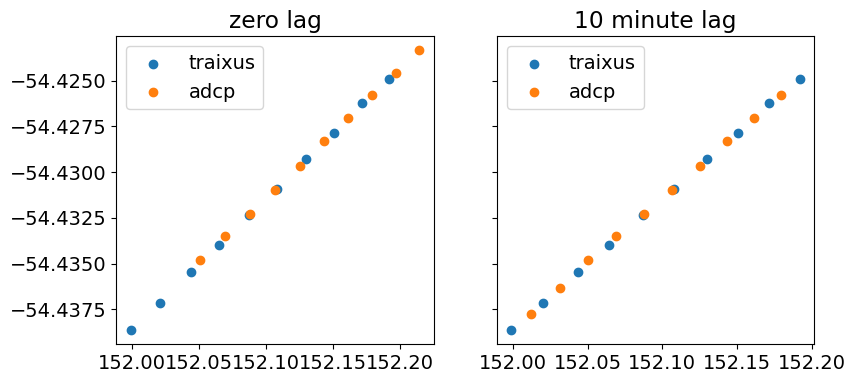

In [17]:
# measurements 20-30
ind = slice(20, 30)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (9,4))
ax1.scatter(triaxus_vertical_cast.longitude[ind], triaxus_vertical_cast.latitude[ind])
ax1.scatter(adcp_zero_lag.lon[ind], adcp_zero_lag.lat[ind])
ax1.legend(['traixus', 'adcp'])
ax1.set_title('zero lag')

ax2.scatter(triaxus_vertical_cast.longitude[ind], triaxus_vertical_cast.latitude[ind])
ax2.scatter(adcp_minus10.lon[ind], adcp_minus10.lat[ind])
ax2.legend(['traixus', 'adcp'])
ax2.set_title('10 minute lag')


In [18]:
adcp_sel = adcp_minus10

In [19]:
u = xr.DataArray(adcp_sel.u.data, dims = ['longitude', 'depth'], 
                 coords = dict(longitude = ('longitude', adcp_sel.lon.data), 
                               depth = ('depth', adcp_sel.depth[0].data)))

v = xr.DataArray(adcp_sel.v.data, dims = ['longitude', 'depth'], 
                 coords = dict(longitude = ('longitude', adcp_sel.lon.data), 
                               depth = ('depth', adcp_sel.depth[0].data)))

In [20]:
print(start, end)

2018-10-29T09:56:51.791321088 2018-10-29T16:17:18.684002304


Text(0, 0.5, 'Latitude [°N]')

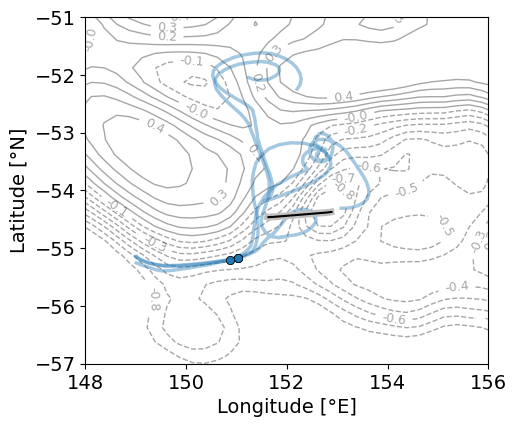

In [21]:
fig, ax = plt.subplots(figsize = (5.2,4.5))

CS = msl.plot.contour(colors = 'k', linewidths = 1, levels = levels, alpha = 0.35)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

plt.plot(adcp_sel.lon, adcp_sel.lat, c= 'silver', linewidth = 5, zorder = 4)
plt.plot(triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude, c= 'k', linewidth = 1.5, zorder = 5)

for floatid in floatids:
    float_num = ema[floatid]
    rs = calc.findRSperiod(float_num)
    plt.plot(float_num.longitude[rs], float_num.latitude[rs], c= 'tab:blue', linewidth = 2.5, alpha = 0.4)

plt.scatter(flt_lons, flt_lats, c= 'tab:blue', edgecolors='k', linewidths = 0.5, s = 35, alpha = 0.85, zorder = 4)

# plt.xlim(148.5, 154)
# plt.ylim(-56, -51.4)

plt.xlim(148, 156)
plt.ylim(-57, -51)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')

# settings.save_figure(fig, my_path, 'map_flts_triaxus.png', dpi = 600, pad = 0.2)

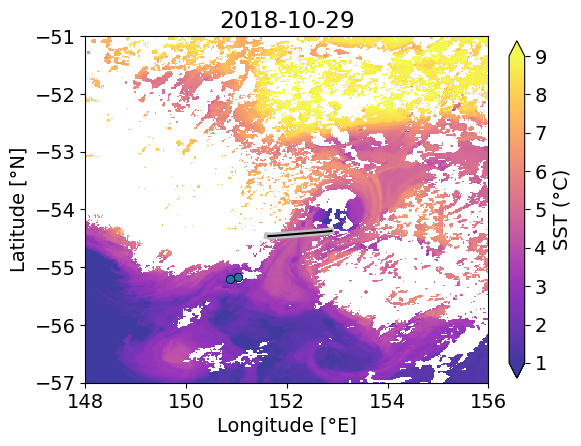

In [22]:
fig, ax = plt.subplots(figsize = (5.2,4.5))
im = msst.plot(vmin = 1, vmax = 9, alpha = 0.8, cmap = 'plasma', extend = 'both', add_colorbar = False)

# CS = msl.plot.contour(colors = 'k', linewidths = 1, levels = levels, alpha = 0.25)
# plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
     
plt.plot(adcp_sel.lon, adcp_sel.lat, c= 'silver', linewidth = 5, zorder = 4)
plt.plot(triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude, c= 'k', linewidth = 1.5, zorder = 5)
plt.scatter(flt_lons, flt_lats, c= 'tab:blue', edgecolors='k', linewidths = 0.5, s = 35, alpha = 0.85, zorder = 4)

ax.set_title('{}'.format(start_time))

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')

plt.xlim(148, 156)
plt.ylim(-57, -51)

cax = plt.axes([0.94, 0.12, 0.03, 0.75])
plt.colorbar(im, cax, label = 'SST (\N{DEGREE SIGN}C)', extend = 'both')

# settings.save_figure(fig, my_path, 'triaxus_tow.png', dpi = 600, pad = 0.2)

(-55.5, -53.5)

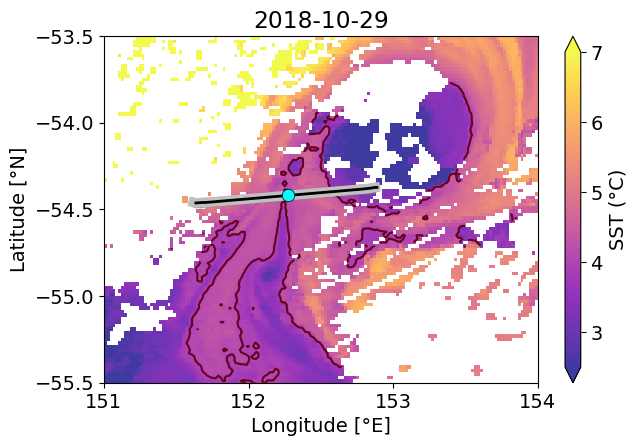

In [23]:
fig, ax = plt.subplots(figsize = (7,4.5))
msst.plot(vmin = 2.5, vmax = 7, alpha = 0.8, cmap = 'plasma', extend = 'both',
                                        cbar_kwargs = dict(label = 'SST (\N{DEGREE SIGN}C)'))

msst.plot.contour(levels = np.arange(4, 4.01, 0.01))

plt.plot(adcp_sel.lon, adcp_sel.lat, c= 'silver', linewidth = 7)      
plt.plot(triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude, c= 'k', linewidth = 2)

plt.scatter(adcp_sel.lon, adcp_sel.lat, c= 'grey', alpha = 0.6)
plt.scatter(triaxus_vertical_cast.longitude[33:34], triaxus_vertical_cast.latitude[33:34], s = 80, c= 'cyan',
                                                                        edgecolors='k', linewidth = 0.5, zorder = 5)


ax.set_title('{}'.format(start_time))
ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')

ax.set_yticks(np.arange(-55.5, -53, 0.5))
ax.set_xticks(np.arange(151, 154.5, 1))

plt.xlim(151,154)
plt.ylim(-55.5, -53.5)

In [23]:
# settings.save_figure(fig, my_path, 'triaxus_SST_enlarged.png', dpi = 600, pad = 0.2)

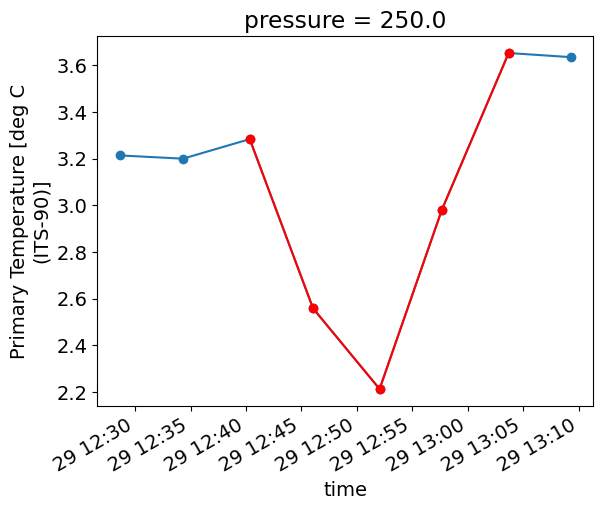

In [26]:
# time of filament crossing
triaxus_vertical_cast.temperature.isel(time = slice(30,38))[250].plot(marker = 'o')

triaxus_vertical_cast.temperature.isel(time = slice(32,37))[250].plot(marker = 'o', c = 'red')

In [27]:
triaxus_vertical_cast.time[34]

<xarray.DataArray 'time' ()>
array('2018-10-29T12:52:02.485004800', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-10-29T12:52:02.485004800
Attributes:
    long_name:      time
    standard_name:  time
    data_min:       62496596.863188684
    data_max:       62496977.31140004
    valid_range:    [62496596.86318868 62496977.31140004]

(-55.5, -53.5)

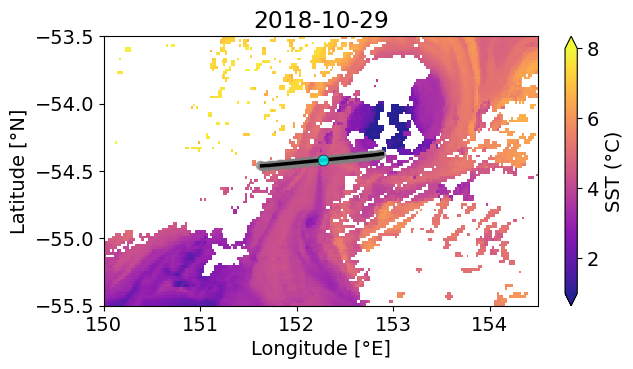

In [29]:
# zoomed-in plot of SST along the traixus transect
fig, ax = plt.subplots(figsize = (7,3.5))

sst = sst_deg.sel(time = start, method = 'nearest')
sst.plot(vmin = 1, vmax = 8, alpha = 0.9, cmap = 'plasma', extend = 'both',
                                        cbar_kwargs = dict(label = 'SST (\N{DEGREE SIGN}C)'))

plt.plot(triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude, c= 'k', linewidth = 2.5)
plt.scatter(adcp_sel.lon, adcp_sel.lat, c= 'grey', alpha = 0.6)
plt.scatter(triaxus_vertical_cast.longitude[33:34], triaxus_vertical_cast.latitude[33:34], s = 60, c= 'cyan', alpha = 0.8,
                                                                        edgecolors='k', linewidth = 0.5, zorder = 5)

plt.title(str(start.astype('M8[D]')))

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')

plt.xlim(150,154.5)
plt.ylim(-55.5, -53.5)

# settings.save_figure(fig, my_path, 'triaxus_tow_zoom2.png', dpi = 600, pad = 0.2)

## Subsurface measurements from the Triaxus

In [30]:
pdens = calc.potentialDensity(triaxus_vertical_cast.pressure, triaxus_vertical_cast.salinity, triaxus_vertical_cast.temperature)
dens_levels = np.arange(26.6, 27.2, 0.04)

In [31]:
imp.reload(calc)
mld = calc.MLD(pdens.transpose(), criteria = 0.02, pref = 10)

Text(0, 0.5, 'pressure (dbar)')

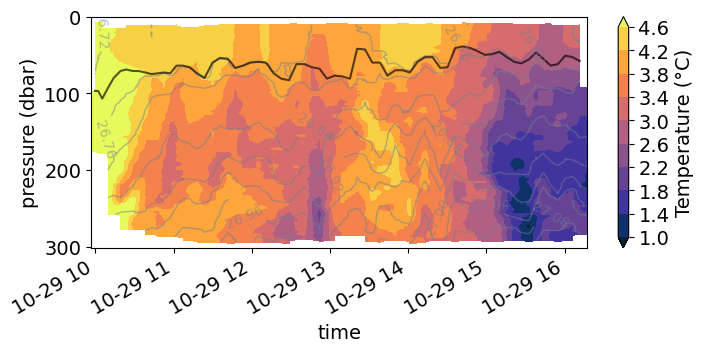

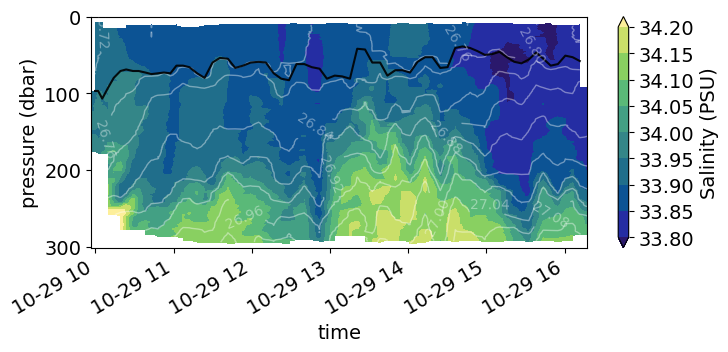

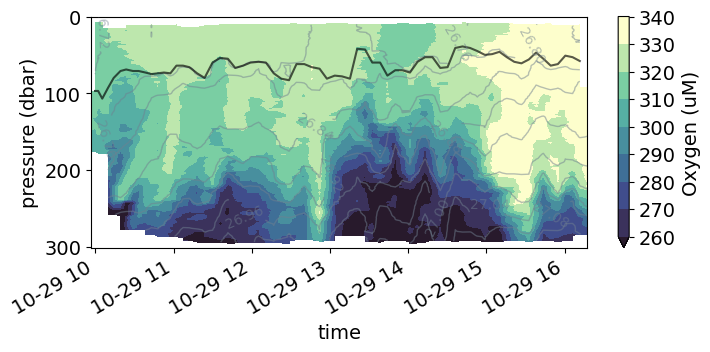

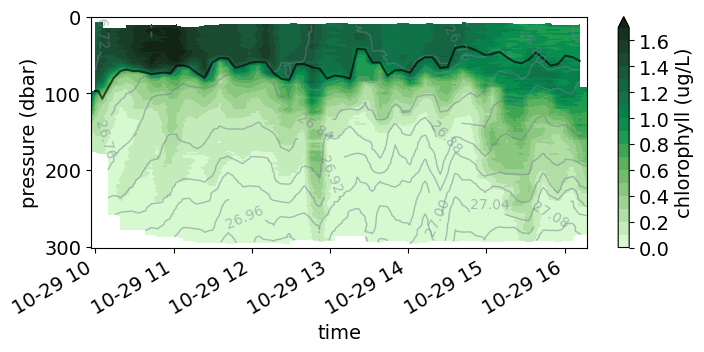

In [32]:
fig, ax = plt.subplots(figsize = (8,3))
triaxus_vertical_cast.temperature.plot.contourf(vmin = 1, vmax = 5, levels = np.arange(1,5,0.4),
                                    cmap = cmocean.cm.thermal, cbar_kwargs = dict(label = 'Temperature (\N{DEGREE SIGN}C)'))

CS = pdens.plot.contour(colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

fig, ax = plt.subplots(figsize = (8,3))
triaxus_vertical_cast.salinity.plot.contourf(vmin = 33.8, vmax = 34.2, levels = np.arange(33.8,34.2,0.05),
                                        cmap = cmocean.cm.haline, cbar_kwargs = dict(label = 'Salinity (PSU)'))
CS = pdens.plot.contour(colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.4)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.9)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

fig, ax = plt.subplots(figsize = (8,3))
triaxus_vertical_cast.oxygen.plot.contourf(vmin = 260, vmax = 350, levels = np.arange(260,350,10),
                                        cmap = cmocean.cm.deep_r, cbar_kwargs = dict(label = 'Oxygen (uM)'))
CS = pdens.plot.contour(colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

fig, ax = plt.subplots(figsize = (8,3))
triaxus_vertical_cast.chlorophyll.plot.contourf(levels = np.arange(0,1.8,0.1),
                                        cmap = cmocean.cm.algae, cbar_kwargs = dict(label = 'chlorophyll (ug/L)'))
CS = pdens.plot.contour(colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

### Temperature anomaly

Text(0, 0.5, 'pressure (dbar)')

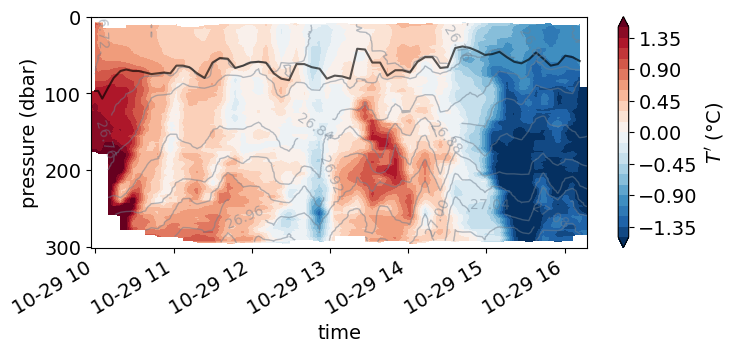

In [33]:
T_anom = triaxus_vertical_cast.temperature - triaxus_vertical_cast.temperature.mean(dim = 'time')

fig, ax = plt.subplots(figsize = (8,3))
T_anom.plot.contourf(vmin = -1.5, vmax = 1.5, levels = np.arange(-1.5,1.6,0.15),
                            cmap = 'RdBu_r', cbar_kwargs = dict(label = '$T^\prime$ (\N{DEGREE SIGN}C)'))
CS = pdens.plot.contour(colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

### Apparent Oxygen Utilisation (AOU)

In [34]:
O2_sol = gsw.O2sol(triaxus_vertical_cast.salinity, triaxus_vertical_cast.temperature, triaxus_vertical_cast.pressure, 
                   triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude)


Text(0, 0.5, 'pressure (dbar)')

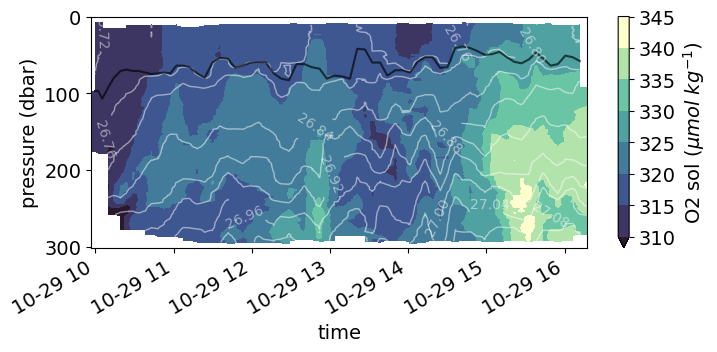

In [36]:
fig, ax = plt.subplots(figsize = (8,3))
O2_sol.plot.contourf(levels = np.arange(310,350,5),
                                        cmap = cmocean.cm.deep_r, cbar_kwargs = dict(label = 'O2 sol ($\mu mol$ $kg^{-1}$)'))
CS = pdens.plot.contour(colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

In [37]:
AOU = O2_sol - triaxus_vertical_cast.oxygen

Text(0, 0.5, 'pressure (dbar)')

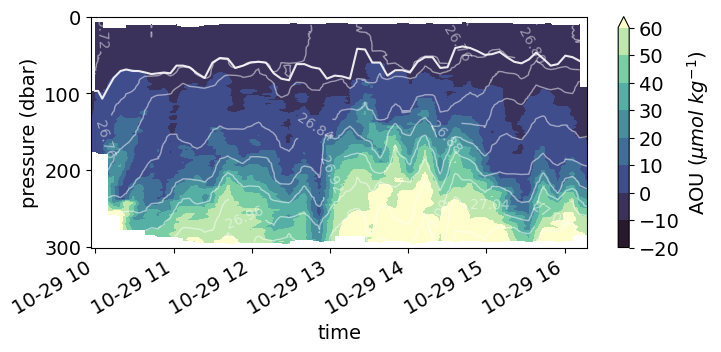

In [39]:
fig, ax = plt.subplots(figsize = (8,3))
AOU.plot.contourf(levels = np.arange(-20,70,10),
                                        cmap = cmocean.cm.deep_r, cbar_kwargs = dict(label = 'AOU ($\mu mol$ $kg^{-1}$)'))
CS = pdens.plot.contour(colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(pdens.time, mld, c = 'w', alpha = 0.9)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')

### ADCP velocities

In [40]:
depth = adcp_sel.depth[0]

In [41]:
v = adcp_sel.v.assign_coords(depth_cell=depth.data)
u = adcp_sel.u.assign_coords(depth_cell=depth.data)

In [42]:
adcp_lons, adcp_lats = adcp_sel.lon, adcp_sel.lat

# smooth gps due to curvature of for the first and last few profiles
adcp_lons = interp.gaussianFilter(adcp_lons, window = 17)
adcp_lats = interp.gaussianFilter(adcp_lats, window = 17)

Text(0.5, 1.0, 'Zonal velocity')

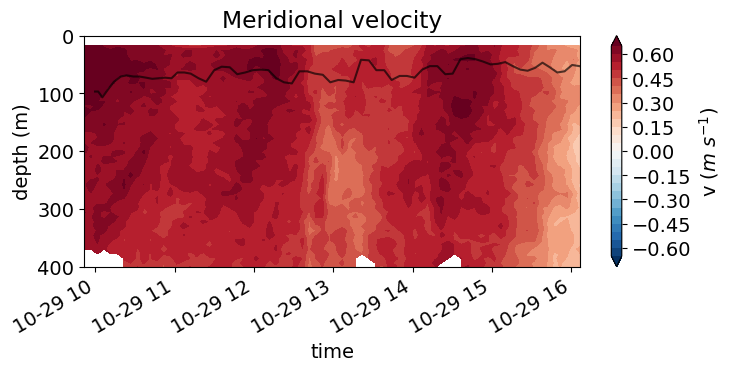

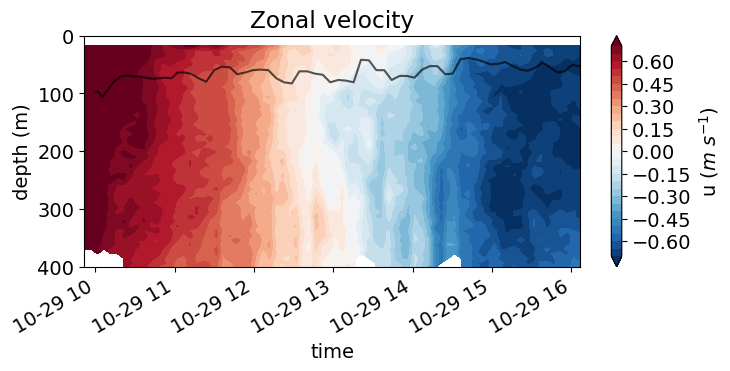

In [43]:
fig, ax = plt.subplots(figsize = (8,3))
v.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.65, 0.7, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'v ($m$ $s^{-1}$)'))
ax.set_ylim(0,400)
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')
plt.title('Meridional velocity')

fig, ax = plt.subplots(figsize = (8,3))
u.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.7, 0.75, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'u ($m$ $s^{-1}$)'))
ax.set_ylim(0,400)
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')
plt.title('Zonal velocity')

In [44]:
u_rot, v_rot, track_bearing = rot_vels(adcp_sel)

Text(0, 0.5, 'depth (m)')

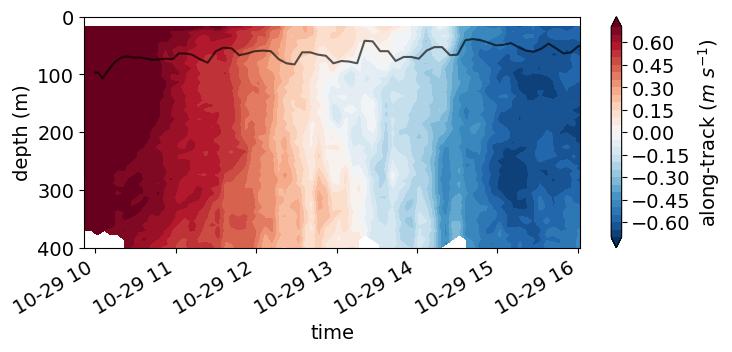

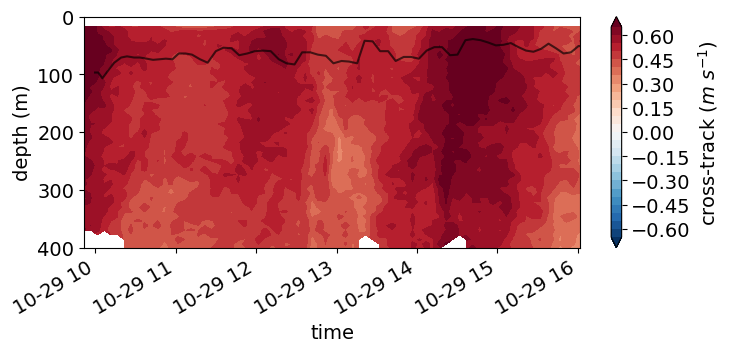

In [45]:
fig, ax = plt.subplots(figsize = (8,3))
u_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.7, 0.75, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'along-track ($m$ $s^{-1}$)'))
ax.set_ylim(0,400)
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

fig, ax = plt.subplots(figsize = (8,3))
v_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.65, 0.7, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'cross-track ($m$ $s^{-1}$)'))
ax.set_ylim(0,400)
plt.plot(pdens.time, mld, c = 'k', alpha = 0.65)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

### Gradients with respect to distance

In [46]:
lons, lats = triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude

In [47]:
dist_diff = np.concatenate((np.array([0]), gsw.distance(lons.values, lats.values)))
dist_diff_km = dist_diff/1000
dist_from_start = np.nancumsum(dist_diff_km)

distance = xr.DataArray(dist_from_start, dims = 'distance')

In [48]:
p = triaxus_vertical_cast.pressure

In [49]:
T_dist = xr.DataArray(triaxus_vertical_cast.temperature.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

S_dist = xr.DataArray(triaxus_vertical_cast.salinity.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

pdens_dist = calc.potentialDensity(p, S_dist, T_dist)

In [50]:
mld_dist = calc.MLD(pdens_dist, criteria = 0.02, pref = 10)

In [51]:
dist_diff = np.concatenate((np.array([0]), gsw.distance(adcp_lons, adcp_lats)))
dist_diff_km = dist_diff/1000
dist_from_start = np.nancumsum(dist_diff_km)

adcp_dist = xr.DataArray(dist_from_start, dims = 'distance')

In [52]:
along_track_u = xr.DataArray(u_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', adcp_dist[:-1].data), 
                                                                                    depth = ('depth', u_rot.depth_cell.data)))
cross_track_v = xr.DataArray(v_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', adcp_dist[:-1].data), 
                                                                                    depth = ('depth', v_rot.depth_cell.data)))

Text(0, 0.5, 'pressure (dbar)')

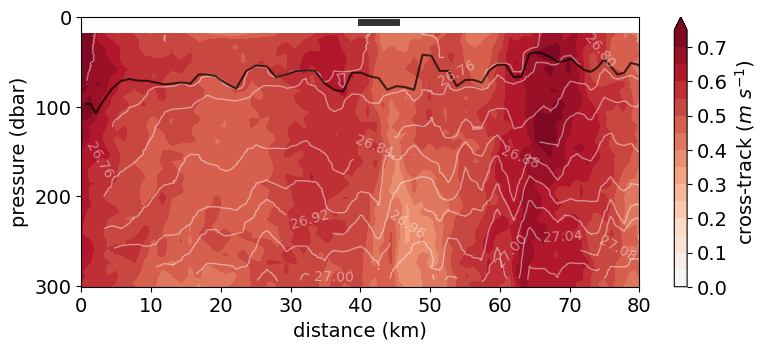

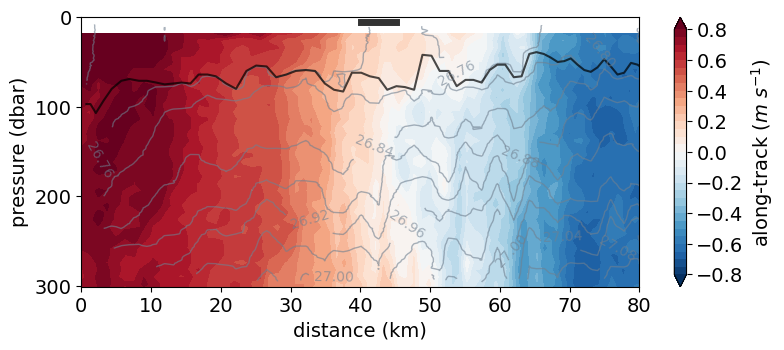

In [54]:
norm = mpl.colors.TwoSlopeNorm(vmin=0, vcenter=1e-5, vmax=0.75)

fig, ax = plt.subplots(figsize = (9, 3.5))
cross_track_v.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(0, 0.775, 0.025), norm = norm,
                                extend = 'max', cbar_kwargs = dict(label = 'cross-track ($m$ $s^{-1}$)'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.45)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan')

mld_dist.plot(c = 'k', alpha = 0.7)
ax.set_ylim(0,T_dist.pressure[-1])
ax.set_xlim(0,80)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'cross_adcp.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9, 3.5))
along_track_u.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'along-track ($m$ $s^{-1}$)'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan')

mld_dist.plot(c = 'k', alpha = 0.7)
ax.set_ylim(0,T_dist.pressure[-1])
ax.set_xlim(0,80)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'along_adcp.png', dpi = 600, pad = 0.2)

### Wind speed and direction

In [55]:
# time at filament location
triaxus_vertical_cast.time[34]

<xarray.DataArray 'time' ()>
array('2018-10-29T12:52:02.485004800', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-10-29T12:52:02.485004800
Attributes:
    long_name:      time
    standard_name:  time
    data_min:       62496596.863188684
    data_max:       62496977.31140004
    valid_range:    [62496596.86318868 62496977.31140004]

In [56]:
port_wind_speed = underway.portTrueWindSpeed.sel(sample = slice('2018-10-27', '2018-10-30'))
stbd_wind_speed = underway.stbdTrueWindSpeed.sel(sample = slice('2018-10-27', '2018-10-30'))
port_wind_dir = underway.portTrueWindDir.sel(sample = slice('2018-10-27', '2018-10-30'))
stbd_wind_dir = underway.stbdTrueWindDir.sel(sample = slice('2018-10-27', '2018-10-30'))

Text(0, 0.5, 'wind speed')

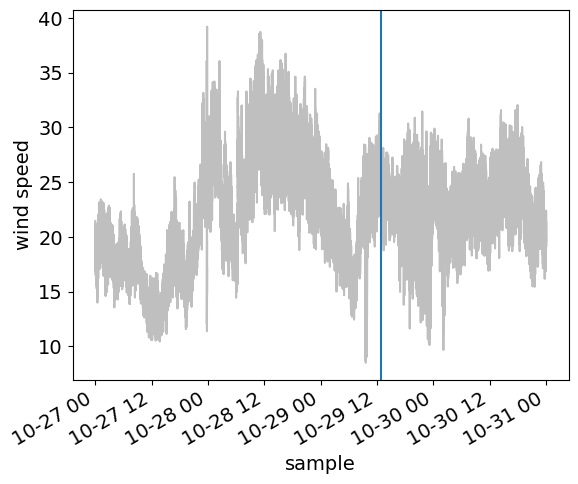

In [57]:
port_wind_speed.plot(c = 'grey', alpha = 0.5)
stbd_wind_speed.plot(c = 'k')
plt.axvline(x = triaxus_vertical_cast.time[34].data)
plt.ylabel('wind speed')

In [58]:
port_wind_speed.sel(sample = triaxus_vertical_cast.time[34].data, method = 'nearest')

<xarray.DataArray 'portTrueWindSpeed' ()>
array(25.46, dtype=float32)
Coordinates:
    sample   datetime64[ns] 2018-10-29T12:52:00
Attributes:
    long_name:  Port True Wind Speed
    units:      knot

Text(0, 0.5, 'wind dir')

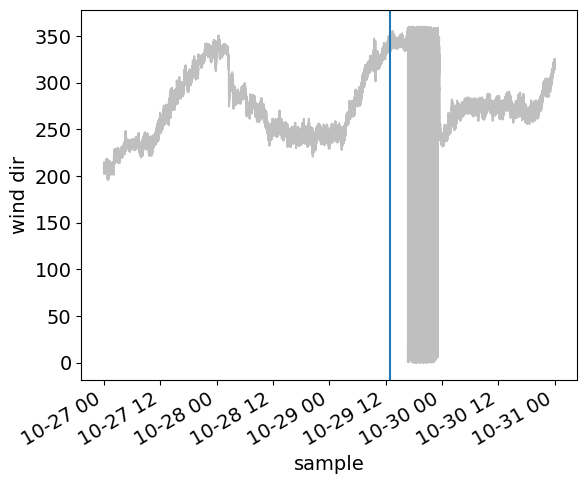

In [59]:
port_wind_dir.plot(c = 'grey', alpha = 0.5)
stbd_wind_dir.plot(c = 'k')
plt.axvline(x = triaxus_vertical_cast.time[34].data)
plt.ylabel('wind dir')

In [60]:
port_wind_dir.sel(sample = triaxus_vertical_cast.time[34].data, method = 'nearest')

<xarray.DataArray 'portTrueWindDir' ()>
array(339.81, dtype=float32)
Coordinates:
    sample   datetime64[ns] 2018-10-29T12:52:00
Attributes:
    long_name:  Port True Wind Direction
    units:      degree

#### Ekman depths based on eddy viscosities estimated in standing meander of the ACC north of Kerguelen Island (Roach et al. 2015)


In [61]:
D_ek = np.sqrt((2*3.25e-2)/gsw.f(54.5))
D_ek

23.397632177897634

In [62]:
D_ek = np.sqrt((2*44.7e-2)/gsw.f(54.5))
D_ek

86.77287570076959

In [63]:
mld_dist.sel(distance = slice(42,52))

<xarray.DataArray (distance: 8)>
array([68., 81., 77., 78., 81., 42., 43., 60.])
Coordinates:
  * distance  (distance) float64 42.63 43.84 45.16 46.38 47.7 48.9 50.19 51.36

### Along track gradients

In [64]:
# even pressure grid
new_grid = np.arange(0,450,8)
v_new = interp.new_pressure_grid(cross_track_v, new_grid, zdim = 'depth')
u_new = interp.new_pressure_grid(along_track_u, new_grid, zdim = 'depth')

In [65]:
dudx = u_new.differentiate('distance')/1000
dvdx = v_new.differentiate('distance')/1000

### Magnitude of horizontal divergence ($\partial u \partial x$)

In [66]:
f = xr.DataArray(gsw.f(adcp_lats)[:-1], dims = 'distance', coords = along_track_u.distance.coords)

Text(0, 0.5, 'depth (m)')

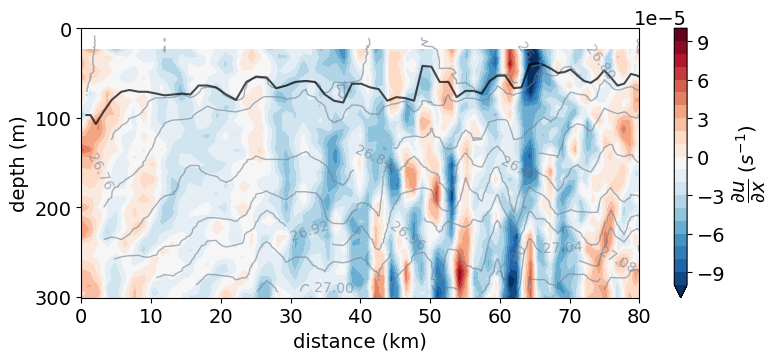

In [69]:
# divergence
fig, ax = plt.subplots(figsize = (9,3.5))
dudx.plot.contourf(x = 'distance', levels = np.arange(-1e-4, 1.1e-4, 1e-5), cmap = 'RdBu_r',
                            cbar_kwargs = dict(label = '$\dfrac{\partial u}{\partial x}$ ($s^{-1}$)'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

mld_dist.plot(c = 'k', alpha = 0.7)
ax.set_ylim(0,T_dist.pressure[-1])
ax.set_xlim(0,80)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

Text(0, 0.5, 'pressure (dbar)')

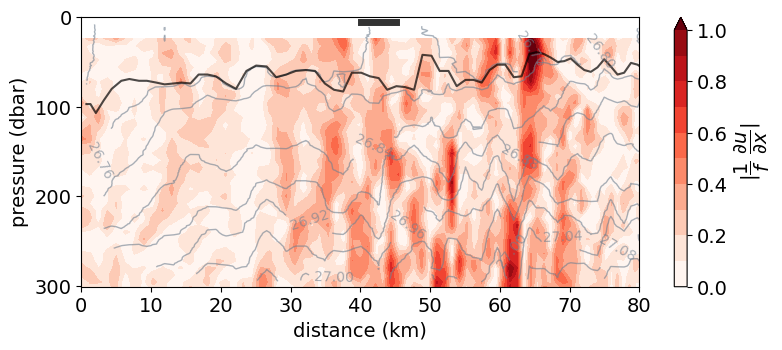

In [68]:
# normalised divergence
fig, ax = plt.subplots(figsize = (9, 3.5))
abs(dudx/f).plot.contourf(x = 'distance', levels = np.arange(0,1.1,0.1), cmap = 'Reds',
                            cbar_kwargs = dict(label = '$|\dfrac{1}{f}$ $\dfrac{\partial u}{\partial x}|$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan')

mld_dist.plot(c = 'k', alpha = 0.7)
ax.set_ylim(0,T_dist.pressure[-1])
ax.set_xlim(0,80)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('pressure (dbar)')
# plt.title('normalised divergence')


# settings.save_figure(fig, my_path, 'normalised_divergence.png', dpi = 600, pad = 0.2)

### Vertical shear

In [70]:
z = -u_new.depth

dudz = np.gradient(u_new)[1]/np.gradient(z)
dvdz = np.gradient(v_new)[1]/np.gradient(z)

dudz = xr.DataArray(dudz, dims = u_new.dims, coords = u_new.coords)
dvdz = xr.DataArray(dvdz, dims = u_new.dims, coords = u_new.coords)

Text(0.5, 1.0, 'dudz')

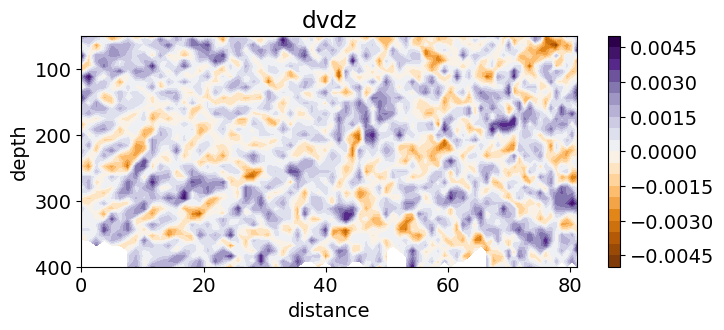

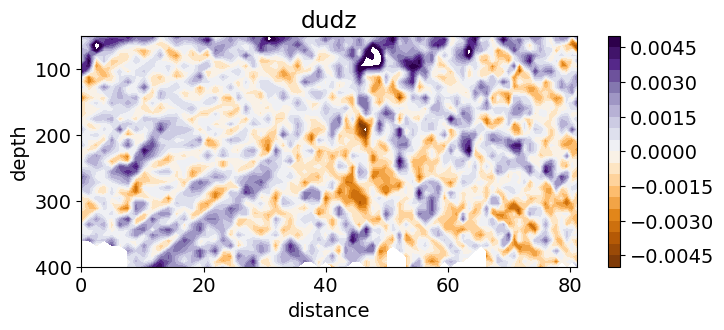

In [71]:
fig, ax = plt.subplots(figsize = (8,3))
dvdz.plot.contourf(x = 'distance', cmap = 'PuOr', extend = 'neither', levels = np.arange(-0.005, 0.0055, 0.0005))
plt.ylim(50,400)
ax.invert_yaxis()
plt.title('dvdz')

fig, ax = plt.subplots(figsize = (8,3))
dudz.plot.contourf(x = 'distance', cmap = 'PuOr', extend = 'neither', levels = np.arange(-0.005, 0.0055, 0.0005))
plt.ylim(50,400)
ax.invert_yaxis()
plt.title('dudz')

### Horizontal buoyancy gradients

In [72]:
rho = pdens_dist + 1000
b = 9.81*(1 - rho/rho.mean())

In [73]:
b_dist = xr.DataArray(b.data, dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', b.pressure.data)))

In [74]:
# horizontal buoyancy gradients
dbdx = b_dist.differentiate('distance')/1000

Text(0, 0.5, 'pressure (dbar)')

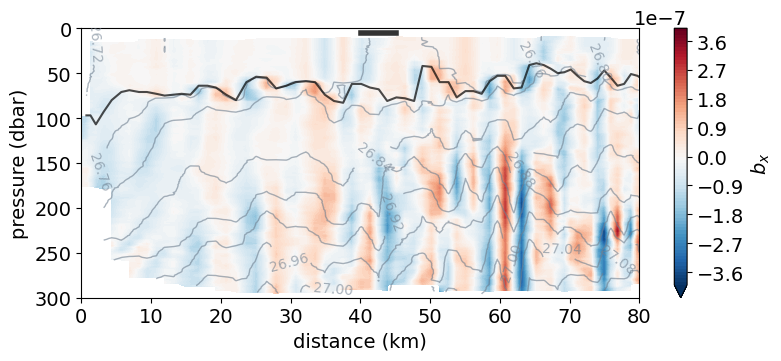

In [75]:
fig, ax = plt.subplots(figsize = (9, 3.5))
dbdx.plot.contourf(x = 'distance', levels = np.arange(-4e-7, 4.1e-7, 1e-8), cbar_kwargs = dict(label = '$b_{x}$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 4)

mld_dist.plot(c = 'k', alpha = 0.7)
ax.set_ylim(0,300)
ax.set_xlim(0,80)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('pressure (dbar)')
# plt.title('normalised divergence')

### Normalise with respect to FSLE orientation (as in Siegelman et al., 2020 NGS)

Divide by the sine of the angle between the instrument track and the FSLE direciton (eigenvector). 

Only normalise where FSLE magnitudes are >0.15/day

In [76]:
fsle_eigenvector, lower, upper = stats.temporalError(triaxus_vertical_cast, fsle_ds.theta_max, method = 'interp', rs = False)
fsle_interp, lower, upper = stats.temporalError(triaxus_vertical_cast, fsle, method = 'interp', rs = False)

In [77]:
# # transform into a bearing from N
# flse_dir = (fsle_eigenvector + 180) % 360 - 180

# fsle_brngs_2d = np.tile(fsle_dir,(len(dbdx.pressure), 1)).transpose()

In [78]:
diff_from_e = 90 - track_bearing[0:71]
diff = (diff_from_e + 270) % 180 - 90

# sin_theta =  np.sin(abs(diff) - abs(fsle_eigenvector))
sin_theta = np.sin(fsle_eigenvector - diff)

Text(0, 0.5, '$\\theta$ (°)')

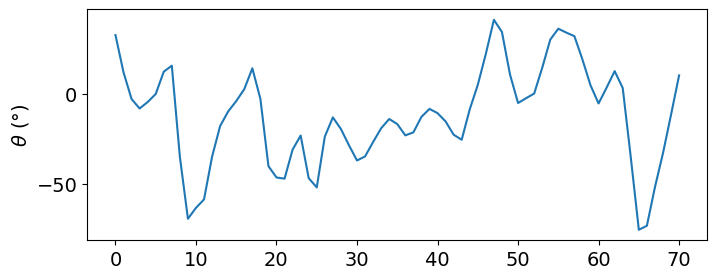

In [79]:
fig, ax = plt.subplots(figsize = (8, 3))
plt.plot(fsle_eigenvector - diff)
plt.ylabel(r'$\theta$ (°)')

In [80]:
2e-7/np.sin(10)

-3.676327921779331e-07

In [81]:
# theta = track_bearing[0:71] - fsle_dir
# theta = (theta + 180) % 360 - 180
# sin_theta = np.sin(theta)

In [82]:
low_fsle = np.where((abs(fsle_interp) < 0.2))[0]
high_fsle = np.where((abs(fsle_interp) > 0.2))[0]
sin_theta[low_fsle] = np.nan
sin_theta_2d = np.tile(sin_theta,(len(dbdx.pressure), 1)).transpose()

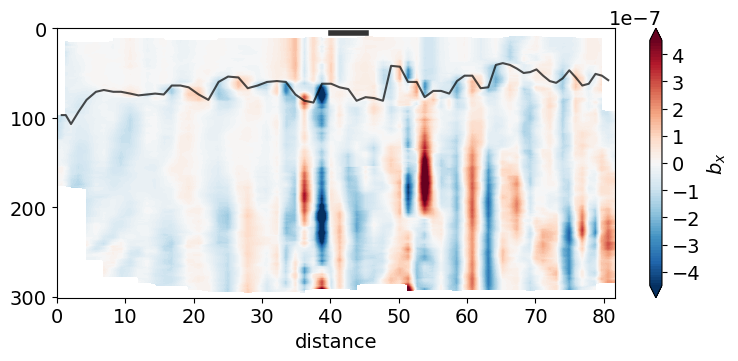

In [83]:
normalised_dbdx = dbdx/sin_theta_2d.data

dbdx_norm = dbdx.copy()
dbdx_norm[high_fsle] = normalised_dbdx[high_fsle]

fig, ax = plt.subplots(figsize = (9, 3.5))
dbdx_norm.plot.contourf(x = 'distance', levels = np.arange(-4.5e-7, 4.6e-7, 1e-8), cbar_kwargs = dict(label = '$b_{x}$'))
mld_dist.plot(c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 4)

ax.invert_yaxis()

Text(0.5, 0, 'distance (km)')

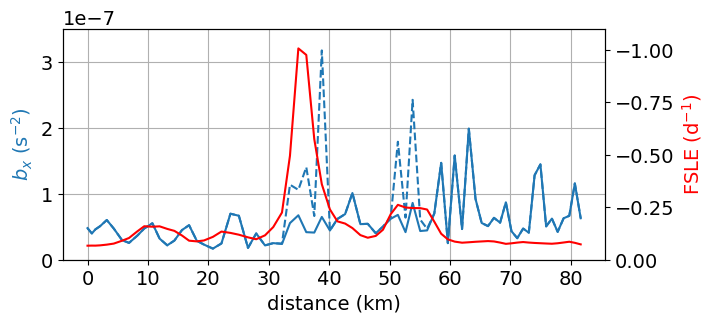

In [84]:
### mean b_x from 0-300 m
fig, ax = plt.subplots(figsize = (7, 3))
abs(dbdx).mean(dim = 'pressure').plot(c = 'tab:blue')
abs(dbdx_norm).mean(dim = 'pressure').plot(c = 'tab:blue', linestyle = '--')
ax.set_ylim(0, 3.5e-7)
ax.set_ylabel('$b_{x}$ (s$^{-2}$)', c = 'tab:blue')
plt.grid()

ax2 = ax.twinx()
xr.DataArray(fsle_interp, dims = 'distance', coords = b_dist.distance.coords).plot(ax = ax2, c = 'red')
ax2.set_ylim(-1.1, 0)
ax2.invert_yaxis()
ax2.set_ylabel('FSLE (d$^{-1}$)', c = 'red')

ax.set_xlabel('distance (km)')

Text(0.5, 0, 'distance (km)')

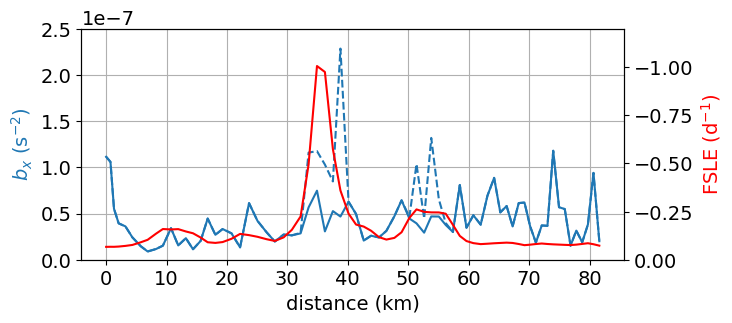

In [85]:
### Mean b_x in the mixed layer (upper 100 m)
fig, ax = plt.subplots(figsize = (7, 3))
abs(dbdx).sel(pressure = slice(0, 100)).mean(dim = 'pressure').plot(c = 'tab:blue')
abs(dbdx_norm).sel(pressure = slice(0, 100)).mean(dim = 'pressure').plot(c = 'tab:blue', linestyle = '--')
ax.set_ylim(0, 2.5e-7)
ax.set_ylabel('$b_{x}$ (s$^{-2}$)', c = 'tab:blue')
plt.grid()

ax2 = ax.twinx()
xr.DataArray(fsle_interp, dims = 'distance', coords = b_dist.distance.coords).plot(ax = ax2, c = 'red')
ax2.set_ylim(-1.2, 0)
ax2.invert_yaxis()
ax2.set_ylabel('FSLE (d$^{-1}$)', c = 'red')

ax.set_xlabel('distance (km)')

### Buoyancy frequency 

In [86]:
# buoyancy frequency 
[N2,p_midarray_n2] = gsw.Nsquared(S_dist, T_dist, T_dist.pressure, axis = 1)

N2 = xr.DataArray(data = N2, dims = ["distance", "pressure"],coords = dict(pressure=(["pressure"], 
    p_midarray_n2[0]),distance=(["distance"], T_dist.distance.data),))

Text(0.5, 0, 'distance (km)')

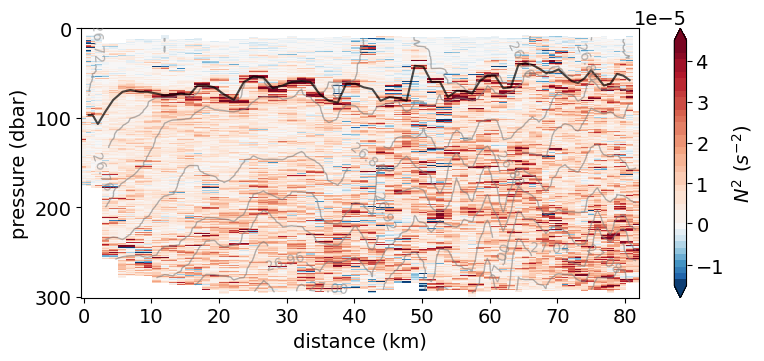

In [88]:
vmin, vmax = -1.5e-5, 4.5e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (9,3.5))
N2.plot(x = 'distance', cmap = 'RdBu_r', norm = norm, levels = np.arange(vmin,vmax, 1.5e-6),
                              cbar_kwargs = dict(label = '$N^{2}$ ($s^{-2}$)'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

In [89]:
# interpolate to pressure mid points (N2 shape)
dvdx_interp_mid = dvdx.interp(depth = N2.pressure, distance = N2.distance)
dudx_interp_mid = dudx.interp(depth = N2.pressure, distance = N2.distance)

dudz_interp_mid = dudz.interp(depth = N2.pressure, distance = N2.distance)
dvdz_interp_mid = dvdz.interp(depth = N2.pressure, distance = N2.distance)

dbdx_interp_mid = dbdx.interp(pressure = N2.pressure, distance = N2.distance)

In [90]:
# Coriolis parameter
f = gsw.f(lats)
f = np.tile(f, (len(N2.pressure),1)).transpose()

In [91]:
imp.reload(calc)
PV = calc.ErtelPV_approximation(N2, dvdx_interp_mid, f, dvdz_interp_mid, dbdx_interp_mid)

# PV = (f + dvdx_interp_mid)*N2 - dvdz_interp_mid*dbdx_interp_mid

Text(0.5, 0, 'distance (km)')

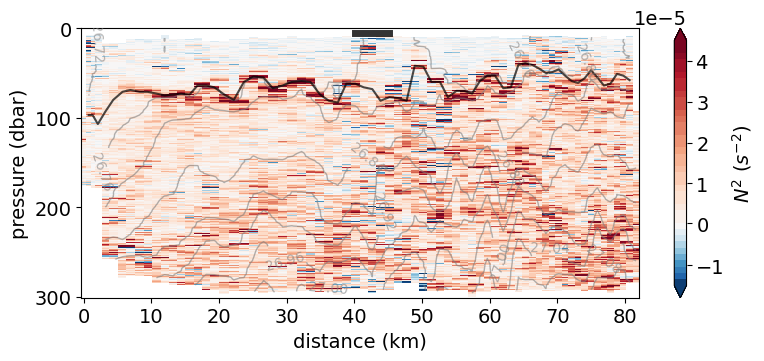

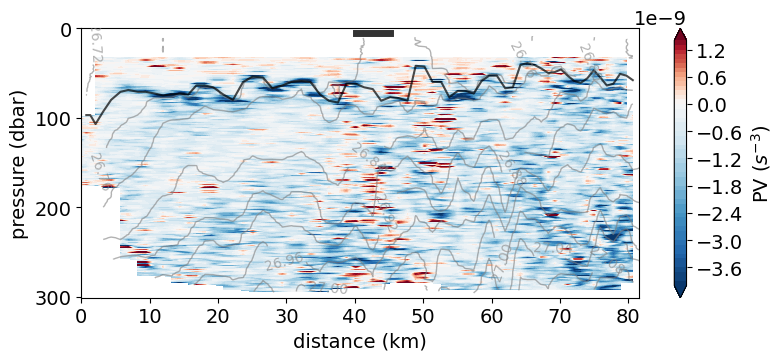

In [92]:
vmin, vmax = -1.5e-5, 4.5e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (9,3.5))
N2.plot(x = 'distance', cmap = 'RdBu_r', norm = norm, levels = np.arange(vmin,vmax, 1.5e-6),
                              cbar_kwargs = dict(label = '$N^{2}$ ($s^{-2}$)'))

#location of cold filament
# plt.plot(N2.distance[32:37], [4, 4, 4, 4, 4],  c= 'k', alpha = 0.8, linewidth = 4)
plt.plot(N2.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)

CS = pdens_dist.plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'N2_Triaxus.png', dpi = 600, pad = 0.2)

vmin, vmax = -4e-9, 1.5e-9
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (9,3.5))
PV.plot.contourf(x = 'distance', norm = norm, levels = np.arange(vmin,vmax, 1e-10), cmap = 'RdBu_r',
                              cbar_kwargs = dict(label = 'PV ($s^{-3}$)'))

#location of cold filament
# plt.plot(N2.distance[32:37], [4, 4, 4, 4, 4],  c= 'k', alpha = 0.8, linewidth = 4)
plt.plot(N2.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)

CS = pdens_dist.plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'PV_Triaxus.png', dpi = 600, pad = 0.2)

Text(0.5, 0, 'distance (km)')

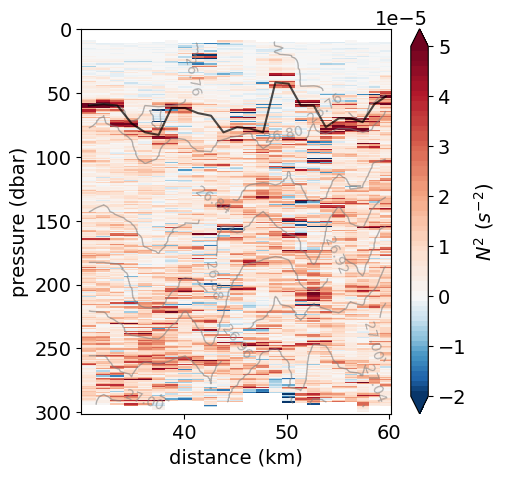

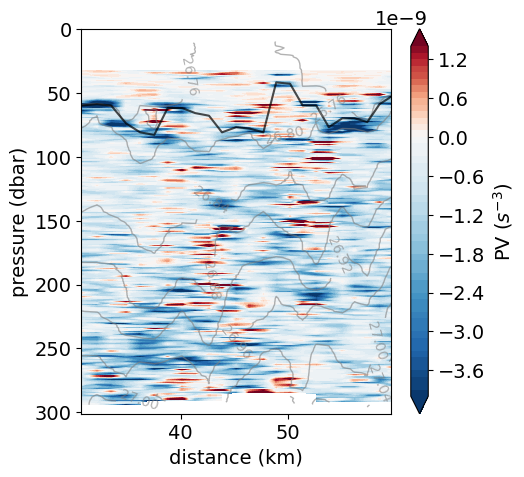

In [93]:
vmin, vmax = -2e-5, 5e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (5,5))
N2.sel(distance = slice(30,60)).plot(x = 'distance', cmap = 'RdBu_r', norm = norm, levels = np.arange(vmin,vmax, 1e-6),
                              cbar_kwargs = dict(label = '$N^{2}$ ($s^{-2}$)'))

CS = pdens_dist.sel(distance = slice(30,60)).plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
mld_dist.sel(distance = slice(30,60)).plot(c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'N2_Triaxus_zoom.png', dpi = 300, pad = 0.2)

vmin, vmax = -4e-9, 1.5e-9
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (5,5))
PV.sel(distance = slice(30,60)).plot.contourf(x = 'distance', norm = norm, levels = np.arange(vmin,vmax, 1e-10), cmap = 'RdBu_r',
                              cbar_kwargs = dict(label = 'PV ($s^{-3}$)'))

# PV.sel(distance = slice(30,60)).plot.contour(x = 'distance', levels = [1e-10], colors = 'tab:red', linewidths = 0.3)

CS = pdens_dist.sel(distance = slice(30,60)).plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
mld_dist.sel(distance = slice(30,60)).plot(c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'PV_Triaxus_zoom.png', dpi = 300, pad = 0.2)

### Background noise in N2

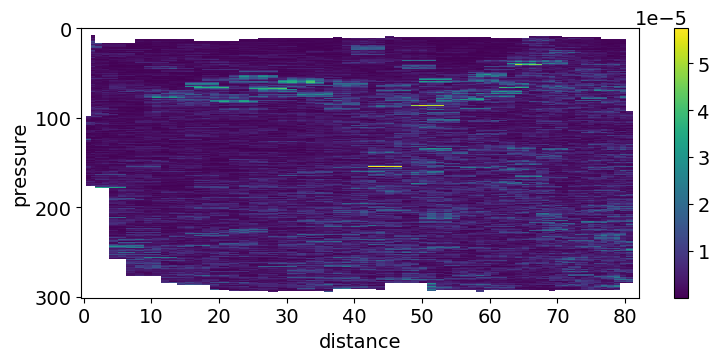

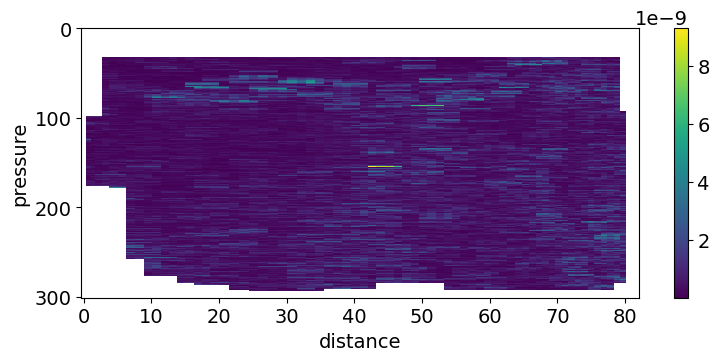

In [94]:
fig, ax = plt.subplots(figsize = (9,3.5))
N2.rolling(distance = 3, center = True).std().plot(x = 'distance')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9,3.5))
PV.rolling(distance = 3, center = True).std().plot(x = 'distance')
ax.invert_yaxis()

In [95]:
N2.rolling(distance = 3, center = True).std().median()

<xarray.DataArray ()>
array(3.30601403e-06)

In [96]:
PV.rolling(distance = 3, center = True).std().median()

<xarray.DataArray ()>
array(4.28350948e-10)

### Potential vorticity components

Text(0.5, 0, 'distance (km)')

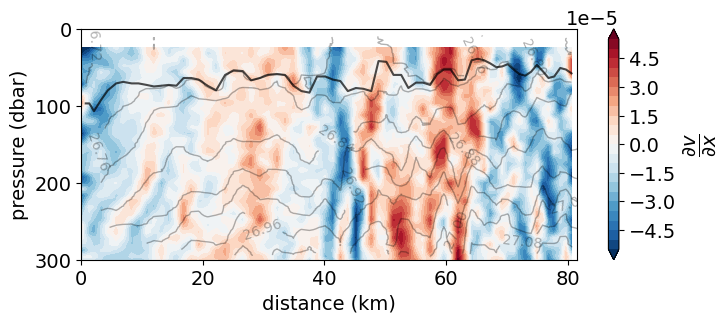

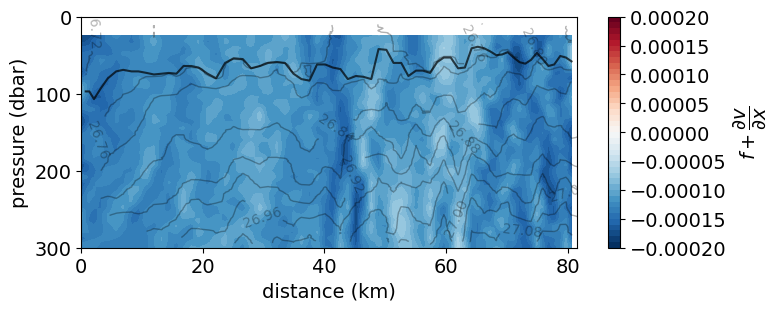

In [97]:
fig, ax = plt.subplots(figsize = (8,3))
dvdx_interp_mid.plot.contourf(x = 'distance', levels = np.arange(-5.5e-5, 6e-5, 5e-6),cmap = 'RdBu_r', 
                              cbar_kwargs = dict(label = r'$\dfrac{\partial v}{\partial x}$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'k', linewidths = 1, levels = dens_levels, alpha = 0.3)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.set_ylim(0, 300)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

fig, ax = plt.subplots(figsize = (8,3))
(f + dvdx_interp_mid).plot.contourf(x = 'distance', levels = np.arange(-2e-4, 2.1e-4, 1e-5),cmap = 'RdBu_r', 
                              cbar_kwargs = dict(label = r'$f + \dfrac{\partial v}{\partial x}$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'k', linewidths = 1, levels = dens_levels, alpha = 0.3)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.set_ylim(0, 300)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

Text(0.5, 0, 'distance (km)')

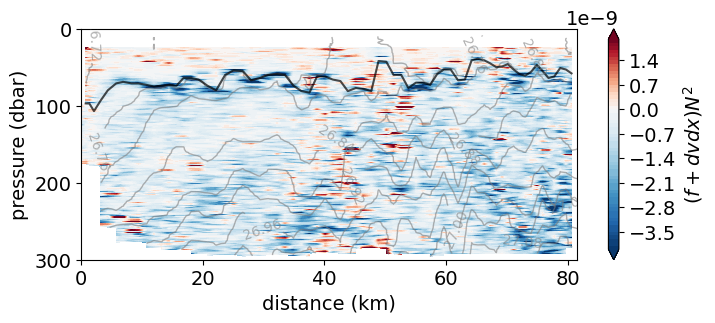

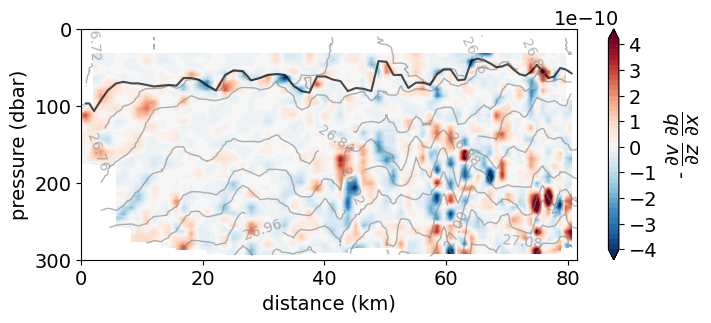

In [98]:
vmin, vmax = -4e-9, 2e-9
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (8,3))
((f + dvdx_interp_mid)*N2).plot.contourf(x = 'distance', norm = norm, levels = np.arange(vmin,vmax, 1e-10),cmap = 'RdBu_r', extend = 'both',
                              cbar_kwargs = dict(label = r'$(f + dvdx)N^{2}$'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.set_ylim(0, 300)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')


fig, ax = plt.subplots(figsize = (8,3))
(-dvdz_interp_mid*dbdx_interp_mid).plot.contourf(x = 'distance', levels = np.arange(-4e-10, 4.2e-10, 2e-11), cmap = 'RdBu_r', extend = 'both',
                              cbar_kwargs = dict(label = r'- $\dfrac{\partial v}{\partial z}$ $\dfrac{\partial b}{\partial x}$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)
ax.set_ylim(0, 300)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

### Richardson number 

In [99]:
shear = (dudz_interp_mid**2 + dvdz_interp_mid**2)
Ri = N2/shear

Text(0.5, 0, 'distance (km)')

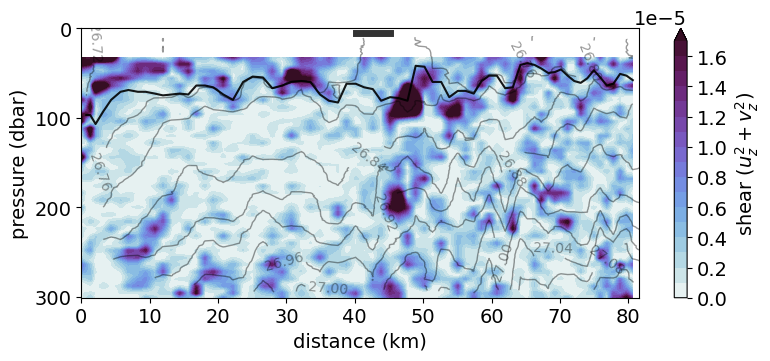

In [100]:
fig, ax = plt.subplots(figsize = (9,3.5))

shear.plot.contourf(x = 'distance', cmap = cmocean.cm.dense, levels= np.arange(0, 1.8e-5, 1e-6),
                cbar_kwargs = dict(label = 'shear $(u_{z}^{2} + v_{z}^{2})$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'k', linewidths = 1, levels = dens_levels, alpha = 0.4)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
plt.plot(T_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)

plt.plot(distance, mld_dist, c = 'k',alpha = 0.9)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

Text(0.5, 0, 'distance (km)')

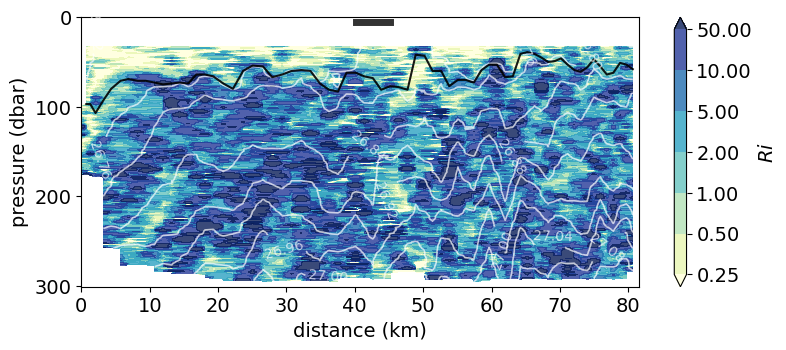

In [101]:
fig, ax = plt.subplots(figsize = (9,3.5))

Ri.plot.contourf(x = 'distance', cmap = 'YlGnBu', levels = np.asarray([0.25, 0.5, 1, 2, 5, 10, 50]), alpha = 0.8, 
                cbar_kwargs = dict(label = '$Ri$'))

CS = pdens_dist.plot.contour(x = 'distance', colors = 'w', linewidths = 1.2, levels = dens_levels, alpha = 0.7)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')

#location of cold filament
# plt.plot(Ri.distance[32:37], [4, 4, 4, 4, 4],  c= 'k', alpha = 0.8, linewidth = 4)
plt.plot(Ri.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)

plt.plot(distance, mld_dist, c = 'k', alpha = 0.9)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'Ri_Triaxus_blues.png', dpi = 600, pad = 0.2)

In [102]:
# Ri.rolling(distance = 3, center = True).std().median()

Text(0.5, 0, 'distance (km)')

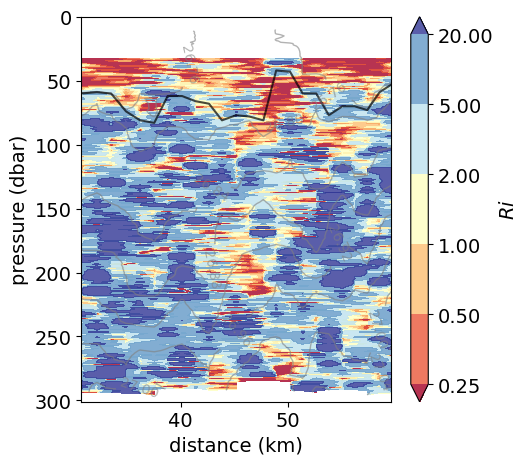

In [104]:
fig, ax = plt.subplots(figsize = (5,5))
Ri.sel(distance = slice(30,60)).plot.contourf(x = 'distance', cmap = 'RdYlBu', levels = np.asarray([0.25, 0.5, 1, 2, 5, 20]),
                              alpha = 0.8, cbar_kwargs = dict(label = '$Ri$'))

CS = pdens_dist.sel(distance = slice(30,60)).plot.contour(x = 'distance', colors = 'grey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
mld_dist.sel(distance = slice(30,60)).plot(c = 'k', alpha = 0.7)
ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'Ri_Triaxus_zoom.png', dpi = 300, pad = 0.2)

### Number of negative values of N2 below the mixed layer in each profile to show where the greatest density of negative values are.

In [105]:
imp.reload(stats)
# neg_N2 = stats.percent_below_mL(N2, mld_dist, condition = '< 0', zmax = 300, dim = 'pressure')
neg_N2 = stats.percent_below_mL(N2, mld_dist, condition = '< -3e-6', zmax = 300, dim = 'pressure')
# pos_PV = stats.percent_below_mL(PV, mld_dist, condition = '> 0', zmax = 300, dim = 'pressure')
pos_PV = stats.percent_below_mL(PV, mld_dist, condition = '> 4e-10', zmax = 300, dim = 'pressure')
o_1_Ri = stats.percent_below_mL(Ri, mld_dist, condition =  ['> 1e-5', '<= 1'], zmax = 300, dim = 'pressure')
# neg_Ri = stats.percent_below_mL(Ri, mld_dist, condition =  '<0', zmax = 300, dim = 'pressure')

(0.0, 35.0)

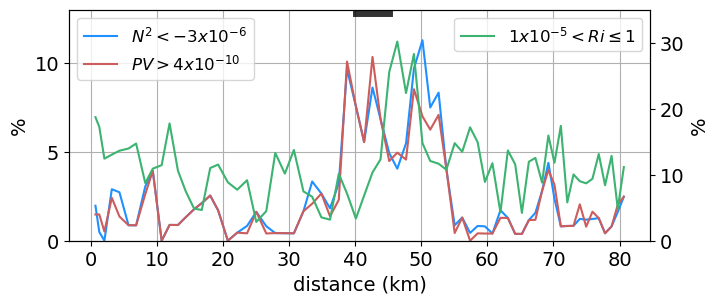

In [107]:
fig, ax = plt.subplots(figsize = (7.5,3))
ax.plot(N2.distance, neg_N2, c = 'dodgerblue',linewidth  = 1.5)
ax.plot(PV.distance, pos_PV, c = 'indianred', linewidth  = 1.5)
plt.legend(['$N^{2}<-3x10^{-6}$', '$PV>4x10^{-10}$'], loc = 'upper left', fontsize = 12)
ax.set_xlabel('distance (km)')
ax.set_ylabel('%')
ax.set_ylim(0, 13)
ax.grid()

#location of cold filament
plt.plot(PV.distance[32:37], [12.8, 12.8,12.8,12.8,12.8],  c= 'k', alpha = 0.8, linewidth = 5)

ax2 = ax.twinx()
ax2.plot(Ri.distance, o_1_Ri, c = 'mediumseagreen',  linewidth  = 1.5)
# ax2.plot(Ri.distance, neg_Ri, c = 'darkgreen', linewidth  = 1.5)
ax2.legend(['$1x10^{-5} < Ri \leq 1$'], loc = 'upper right', fontsize = 12)
ax2.set_ylabel('%')
ax2.set_ylim(0, 35)

In [108]:
# settings.save_figure(fig, my_path, 'count_values_N2_PV_Ri.png', dpi = 600, pad = 0.2)

### Plots by distance

In [109]:
O2_dist = xr.DataArray(triaxus_vertical_cast.oxygen.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

T_anom_dist = xr.DataArray(T_anom.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

AOU_dist = xr.DataArray(AOU.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

chl_dist = xr.DataArray(triaxus_vertical_cast.chlorophyll.data.transpose(), dims = ['distance', 'pressure'], coords = dict(distance = ('distance', distance.data), 
                                                                                    pressure = ('pressure', p.data)))

In [110]:
pdens_dist.distance[33:35].mean()

<xarray.DataArray 'distance' ()>
array(41.99605664)

Text(0.5, 0, 'distance (km)')

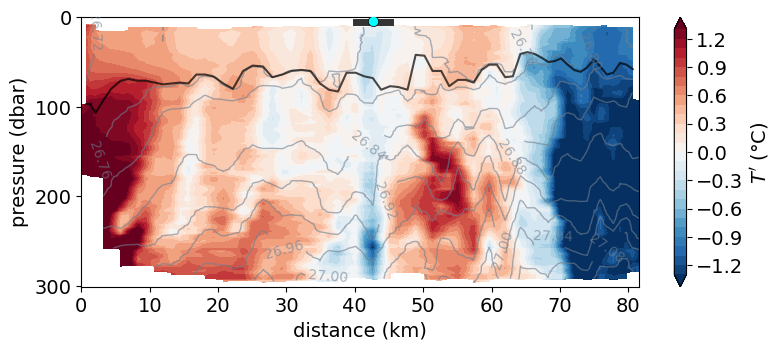

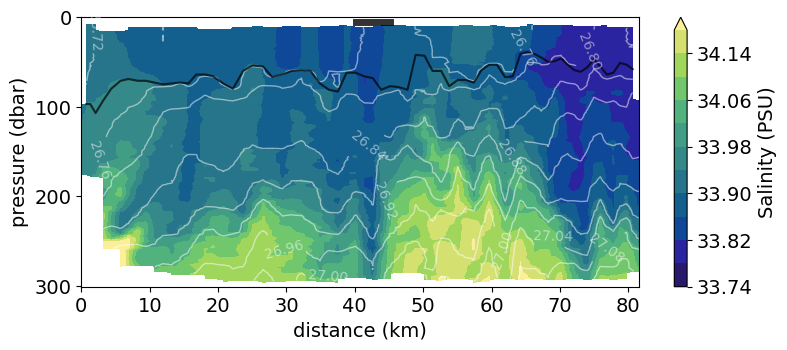

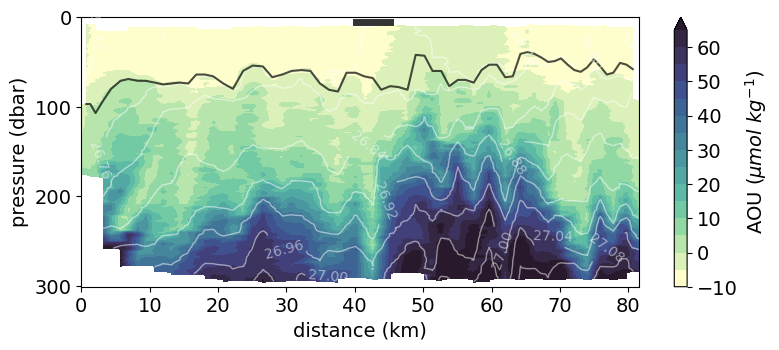

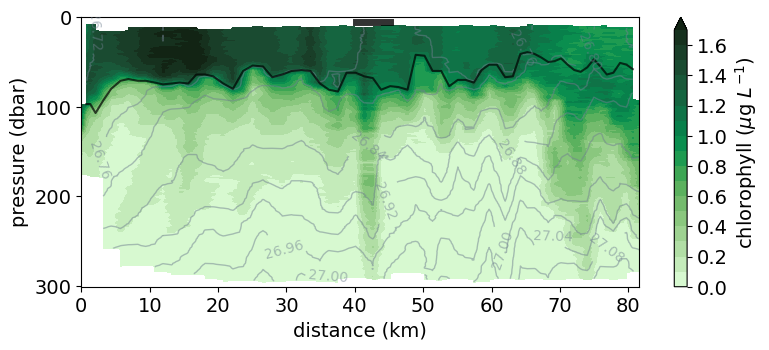

In [111]:
fig, ax = plt.subplots(figsize = (9,3.5))
T_anom_dist.plot.contourf(x = 'distance', levels = np.arange(-1.3,1.4,0.1),
                                        cmap = 'RdBu_r', cbar_kwargs = dict(label = '$T^\prime$ (\N{DEGREE SIGN}C)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
plt.scatter(pdens_dist.distance[34], 4, s = 55, c= 'cyan',edgecolors='k', linewidth = 0.5, zorder = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan', alpha = 0.8)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'Tanom_triaxus.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9,3.5))
S_dist.plot.contourf(x = 'distance', levels = np.arange(33.74,34.2,0.04),
                                        cmap = cmocean.cm.haline, cbar_kwargs = dict(label = 'Salinity (PSU)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan', alpha = 0.8)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'Sal_triaxus.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9,3.5))
AOU_dist.plot.contourf(x = 'distance', levels = np.arange(-10,70,5),
                                        cmap = cmocean.cm.deep, cbar_kwargs = dict(label = 'AOU ($\mu mol$ $kg^{-1}$)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan', alpha = 0.8)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'AOU_triaxus.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9,3.5))
chl_dist.plot.contourf(x = 'distance', levels = np.arange(0,1.8,0.1),
                                        cmap = cmocean.cm.algae, cbar_kwargs = dict(label = 'chlorophyll ($\mu$g $L^{-1}$)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

# #location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 5)
# ax.axvline(x = pdens_dist.distance[34], c = 'cyan', alpha = 0.8)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

# settings.save_figure(fig, my_path, 'Chl_triaxus.png', dpi = 600, pad = 0.2)

Text(0.5, 0, 'distance (km)')

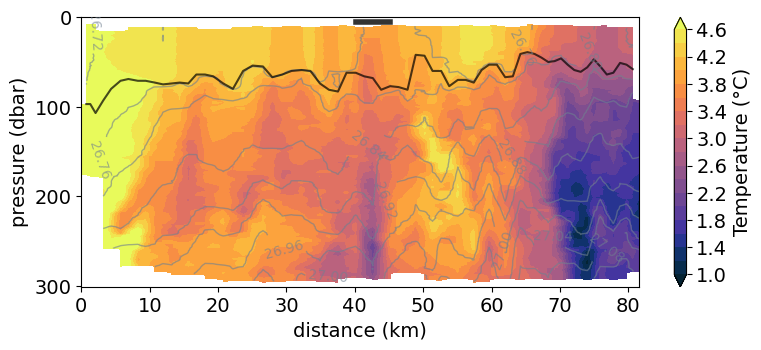

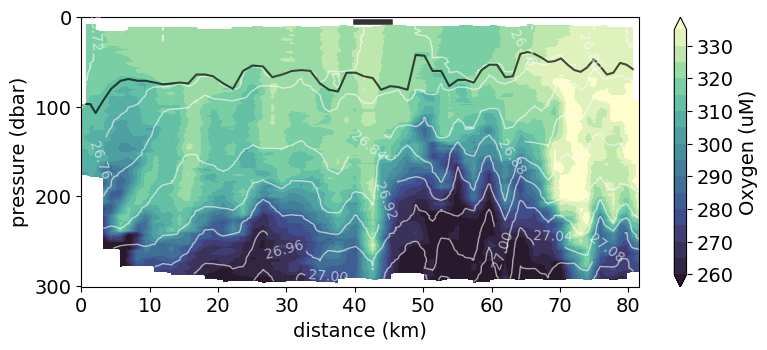

In [112]:
fig, ax = plt.subplots(figsize = (9,3.5))
T_dist.plot.contourf(x = 'distance', levels = np.arange(1,4.8,0.2),
                                    cmap = cmocean.cm.thermal, cbar_kwargs = dict(label = 'Temperature (\N{DEGREE SIGN}C)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 4)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')


fig, ax = plt.subplots(figsize = (9,3.5))
O2_dist.plot.contourf(x = 'distance', levels = np.arange(260,340,5),
                                        cmap = cmocean.cm.deep_r, cbar_kwargs = dict(label = 'Oxygen (uM)'))
CS = pdens_dist.plot.contour(x = 'distance', colors = 'w', linewidths = 1, levels = dens_levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.2f')
plt.plot(distance, mld_dist, c = 'k', alpha = 0.7)

#location of cold filament
plt.plot(pdens_dist.distance[32:37], [5, 5, 5, 5, 5],  c= 'k', alpha = 0.8, linewidth = 4)

ax.invert_yaxis()
plt.ylabel('pressure (dbar)')
plt.xlabel('distance (km)')

### Satellite data

In [113]:
var = fsle
label = 'FSLE ($day^{-1}$)'
ymin, ymax = -1.2, 0
c = 'tab:blue'

# var = ow
# ymin, ymax = -7.5e-11, 7.5e-11
# label = 'Okubo-Weiss ($s^{-2}$)'
# c = 'tab:red'

Text(0.5, 0, 'distance (km)')

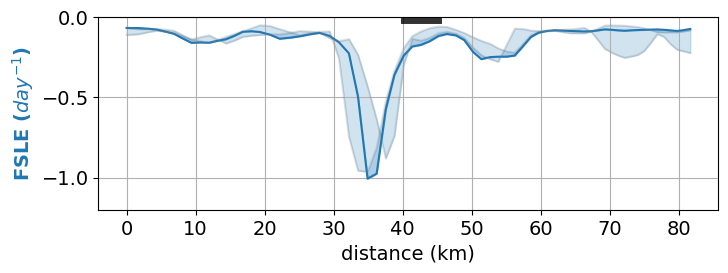

In [114]:
imp.reload(stats)

fig, ax = plt.subplots(figsize = (8,2.5))

interp_val, lower, upper = stats.temporalError(triaxus_vertical_cast, var, method = 'interp', rs = False)

plt.plot(distance, interp_val, c = c)
plt.plot(distance, lower, c = 'grey', alpha = 0.2)
plt.plot(distance, upper, c = 'grey', alpha = 0.2)

ax.fill_between(distance, lower, interp_val, alpha=0.2, color = c)
ax.fill_between(distance, interp_val, upper, alpha=0.2, color = c)

#location of cold filament
# plt.plot(pdens_dist.distance[32:37], [7.2e-11, 7.2e-11, 7.2e-11, 7.2e-11, 7.2e-11],  c= 'k', alpha = 0.8, linewidth = 5)
plt.plot(pdens_dist.distance[32:37], [-0.02, -0.02, -0.02, -0.02, -0.02],  c= 'k', alpha = 0.8, linewidth = 5)

ax.grid()
ax.set_ylabel(label, c = c, fontweight = 'bold')
ax.set_ylim(ymin, ymax)
ax.set_xlabel('distance (km)')

# plt.axhline(y = 0, linestyle = '--', c = 'grey')

In [115]:
# settings.save_figure(fig, my_path, 'FSLE_interp.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'ow_interp.png', dpi = 600, pad = 0.2)

### Surface maps

In [116]:
# latmin, latmax = -56, -53
latmin, latmax = -57, -51
lonmin, lonmax = 148,155 #150,155

var = ow
vmin, vmax = -3e-11, 3e-11
cmap = 'RdBu_r'
label = 'Okubo-Weiss ($s^{-2}$)'
extend = 'both'

# var = fsle
# vmin, vmax = -0.6, 0
# cmap = 'YlGnBu_r'
# label = u'FSLE ($day^{-1}$)'
# extend = 'min'

Text(0, 0.5, 'Latitude [°N]')

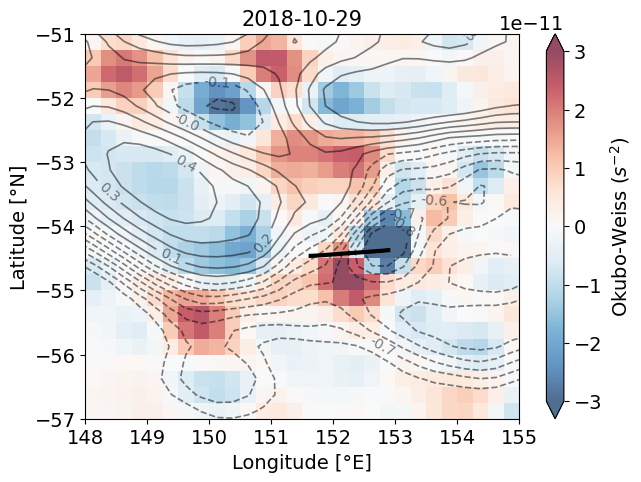

In [117]:
start = triaxus_vertical_cast.time[0].values
end = triaxus_vertical_cast.time[-1].values

start_time, end_time = str(start.astype('M8[D]')),  str(end.astype('M8[D]'))
mean_var = var.sel(time = slice(start_time, end_time)).mean(dim = 'time', skipna = True)

levels = np.arange(-0.8,0.4,0.1)
msl = alt_cmems.adt.sel(time = slice(start_time, end_time)).mean(dim = 'time')


fig, ax = plt.subplots(figsize = (7,5))

mean_var.sel(latitude = slice(latmin, latmax), longitude = slice(lonmin , lonmax)).plot(vmin = vmin, vmax = vmax, alpha = 0.7, 
                                                                         cmap = cmap, extend = extend,
                                                                        cbar_kwargs = dict(label = label))

# mean_var.plot.contourf(levels = np.arange(-4.6e-11, 4.8e-11, 2e-12), cmap = cmap, cbar_kwargs = dict(label = label))

plt.plot(triaxus_vertical_cast.longitude, triaxus_vertical_cast.latitude, c = 'k',linewidth = 3, zorder = 4)

CS = msl.plot.contour(colors = 'k', linewidths = 1.2, levels = levels, alpha = 0.5, zorder = 4)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')



ax.set_ylim(latmin, latmax)
# ax.set_xlim(150,155)

ax.set_title(start_time, fontsize = 15)

ax.set_xlabel(u'Longitude [\N{DEGREE SIGN}E]')
ax.set_ylabel(u'Latitude [\N{DEGREE SIGN}N]')

In [118]:
# settings.save_figure(fig, my_path, 'FSLE_map_larger.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'ow_map_larger.png', dpi = 600, pad = 0.2)